<a href="https://colab.research.google.com/github/IagoMagalhaes23/Machine-Learning-com-Frameworks/blob/main/Arima_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Algoritmo ARIMA para regressão - AutoRegressive Integrated Moving Average

##Descrição do algoritmo
###O ARIMA utiliza dados passados ​​para prever o futuro, usando os dois principais recursos: uma autocorrelação e médias móveis. Além disso, a ARIMA possui algumas vertentes, como modelos que permitem identificar e considerar a sazonalidade (SARIMA), modelos AR, MA, ARMA e por aí vai.

##Importando bibliotecas

In [6]:
from google.colab import files

import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

plt.style.use("seaborn")
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

##Acessando base de dados

In [2]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('Arquivo carregado com sucesso! \n "{name}" com tamanho de {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving daily-minimum-temperatures.csv to daily-minimum-temperatures.csv
Arquivo carregado com sucesso! 
 "daily-minimum-temperatures.csv" com tamanho de 67923 bytes


##Plotando dados

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8
1981-01-06  15.8
1981-01-07  15.8
1981-01-08  17.4
1981-01-09  21.8
1981-01-10  20.0
1981-01-11  16.2
1981-01-12  13.3
1981-01-13  16.7
1981-01-14  21.5
1981-01-15  25.0
1981-01-16  20.7
1981-01-17  20.6
1981-01-18  24.8
1981-01-19  17.7
1981-01-20  15.5


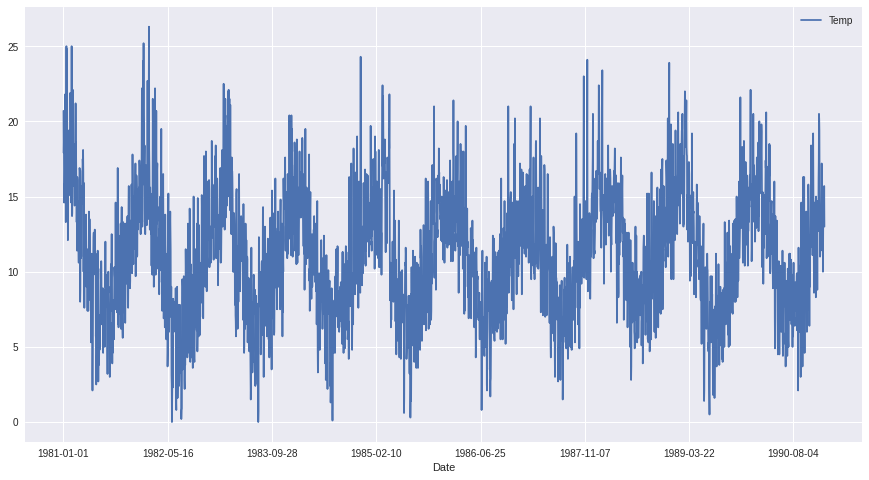

In [3]:
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0)

print(series.head(20))

series.plot(figsize = (15,8))
plt.show()

##Separando dados de treino e teste

In [4]:
# split the dataset

series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0)

split_point = len(series) - 7

dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

print(); print(dataset.tail())
print(); print(validation.head())

dataset.to_csv('dataset.csv', index=False)
validation.to_csv('validation.csv', index=False)

Dataset 3643, Validation 7

            Temp
Date            
1990-12-20  15.4
1990-12-21  13.1
1990-12-22  13.2
1990-12-23  13.9
1990-12-24  10.0

            Temp
Date            
1990-12-25  12.9
1990-12-26  14.6
1990-12-27  14.0
1990-12-28  13.6
1990-12-29  13.5


##Como encontrar a ordem do termo AR (p)
###A próxima etapa é identificar se o modelo precisa de algum termo AR. Você pode descobrir o número necessário de termos AR inspecionando o gráfico de Autocorrelação Parcial (PACF).

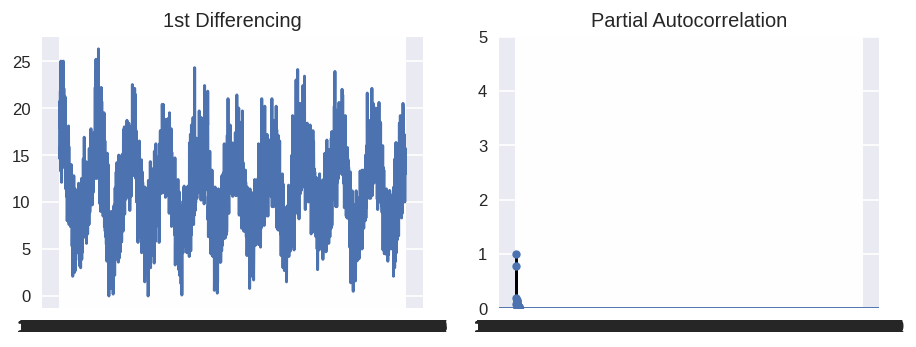

In [7]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data
df = pd.read_csv('daily-minimum-temperatures.csv', header=0, index_col=0)

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.dropna(), ax=axes[1])

plt.show()

##Como encontrar a ordem do termo MA (q)
###Assim como olhamos para o gráfico PACF para o número de termos AR, você pode olhar para o gráfico ACF para o número de termos MA. Um termo MA é, tecnicamente, o erro da previsão defasada.

###O ACF informa quantos termos MA são necessários para remover qualquer autocorrelação na série estacionarizada.

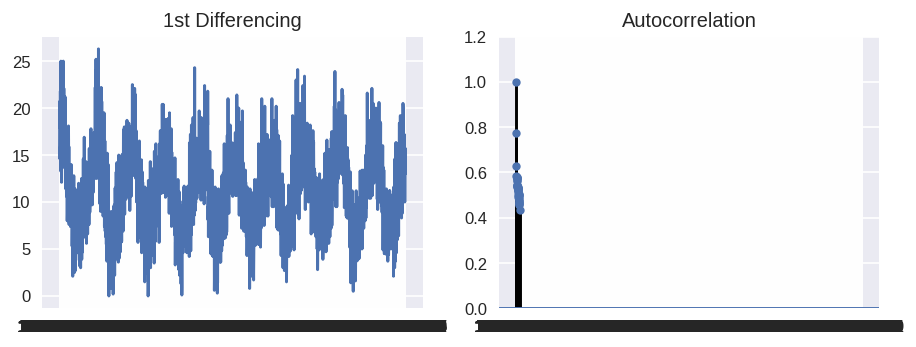

In [8]:
# Import data
df = pd.read_csv('daily-minimum-temperatures.csv', header=0, index_col=0)

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.dropna(), ax=axes[1])

plt.show()

##Criando e treinando modelo ARIMA

In [9]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# load dataset
series = read_csv('dataset.csv', header=0)

# seasonal difference
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)

# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit()

# print summary of fit model
print()
print(model_fit.summary())


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3278
Model:                     ARMA(7, 1)   Log Likelihood               -8673.748
Method:                       css-mle   S.D. of innovations              3.411
Date:                Wed, 03 Nov 2021   AIC                          17367.497
Time:                        22:33:19   BIC                          17428.447
Sample:                             0   HQIC                         17389.322
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.132      0.100      0.921      -0.246       0.273
ar.L1.y        1.1426      0.287      3.977      0.000       0.580       1.706
ar.L2.y       -0.4347      0.154     -2.830      0.

##Testando modelo

In [10]:
#Data validation
resultado = []

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load dataset
series = read_csv('dataset.csv', header=0)

# seasonal difference
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)

# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit()

# multi-step out-of-sample forecast
start_index = len(differenced)
end_index = start_index + 6
forecast = model_fit.predict(start=start_index, end=end_index)

# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    resultado.append(inverted)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1

Day 1: 14.861659
Day 2: 15.628796
Day 3: 13.331347
Day 4: 11.722408
Day 5: 10.421524
Day 6: 14.415542
Day 7: 12.674725


##Plotando gráfico com resultado esperado e previsto

   Temp
0  12.9
1  14.6
2  14.0
3  13.6
4  13.5
5  15.7
6  13.0


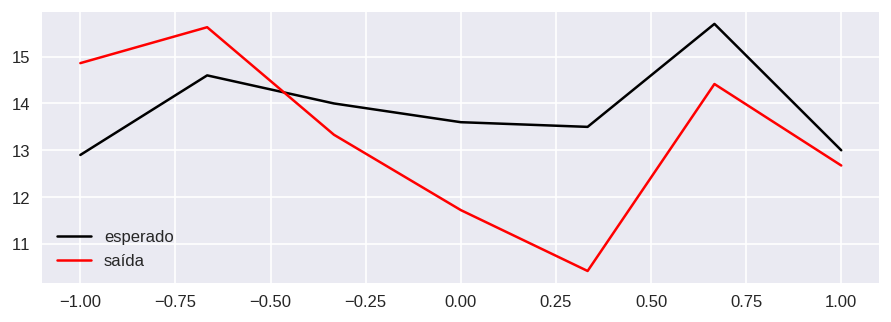

In [11]:
esperado = read_csv("validation.csv")
print(esperado)
plt.plot(np.linspace(-1, 1, 7), esperado, label='esperado', color='black', linewidth=1.5)
plt.plot(np.linspace(-1, 1, 7), resultado, label='saída', color='red', linewidth=1.5)
plt.legend()
plt.show()

##Plotando métricas de avaliações

In [12]:
print('Erro máx.: ')
print(max_error(esperado,resultado))
print('-----------------------------')

print('Erro médio absoluto: ')
print(mean_absolute_error(esperado,resultado))
print('-----------------------------')

print('Erro quadrático absoluto: ')
print(mean_squared_error(esperado,resultado))
print('-----------------------------')

print('Raiz do Erro quadrático médio: ')
print(mean_squared_error(esperado, resultado, squared=False))

Erro máx.: 
3.0784755553115453
-----------------------------
Erro médio absoluto: 
1.460701309736142
-----------------------------
Erro quadrático absoluto: 
2.873089271024596
-----------------------------
Raiz do Erro quadrático médio: 
1.695018958898276
